In [1]:
from sklearn import svm
from sklearn import linear_model
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import math
import joblib
import copy
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima_model import ARIMA
from genetic_selection import GeneticSelectionCV

# Read FRED data
djia_stat = {}
news_stat = {}
djia_st = 0

start_date = (datetime.datetime.strptime("2018-11-09", "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()

with open("DJIA.csv", "r") as djia_r:
    djia_r.readline()
    djia_close = []
    for l in djia_r:
        x = l.strip().split(",")
        if x[1] == ".": # Skip days for which there are no values.
            continue
        u = [(datetime.datetime.strptime(x[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds(), djia_close[-1] if len(djia_close) != 0 else float(x[1]), djia_close[-2] if len(djia_close) > 1 else float(x[1])]
        if x[0] == "2018-11-09": # Check this date
            djia_st = len(djia_stat)
        v = float(x[1]) # Output value
        djia_close.append(v)
        djia_stat[u[0]] = u[1:] + [v]

with open("DJIAHeadlines.csv", "r") as headlines_r:
    for l in headlines_r:
        vals = l.split(",")
        news_stat[(datetime.datetime.strptime(vals[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()] = [int(x) for x in vals[1:]]

# Toss out any data before start_date
ks = copy.deepcopy(list(djia_stat.keys()))
for k in ks:
    if k < start_date:
        del djia_stat[k]
    
# Assume these will both be arrays.
def dict_zip(djia, other):
    k = djia.keys() # Only use DJIA keys as it is closed more often than the news
    res = []
    for x in k:
        res.append([x] + other[x] + djia[x])
    return res
        
def fit(djia_s):
    djia_in = []
    djia_out = []
    dat_ = djia_s
    dat = []
    
    dat = dat_
    split = int(.8 * len(dat))

    scaler = MinMaxScaler()
    scaler.fit(dat)
    djia_s = scaler.transform(dat)

    djia_in = [x[:-1] for x in djia_s]
    djia_out = [x[-1] for x in djia_s]

    djia_in_train = np.array(djia_in[:split])
    djia_out_train = np.array(djia_out[:split])
    djia_in_test = np.array(djia_in[split:])
    djia_out_test = np.array(djia_out[split:])

    m = svm.SVR(C=0.01, cache_size=1000, coef0=djia_out_train[-1], degree=5, epsilon=0.001, gamma='auto', kernel='poly', max_iter=5000, shrinking=True, tol=0.0001, verbose=True)

    model = m.fit(djia_in_train, djia_out_train)
    res = copy.deepcopy(m.predict(djia_in_test))

    m2 = GeneticSelectionCV(m, cv=5, verbose=1, scoring="neg_mean_squared_error", n_population=1000, crossover_proba=0.5, mutation_proba=0.2, n_generations=3000, crossover_independent_proba=0.5, mutation_independent_proba=0.05, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=10)
    m2.fit(djia_in_train, djia_out_train)

    res2 = m2.predict(djia_in_test)
    
    mk = KernelRidge(alpha=1)
    mk.fit(djia_in_train, djia_out_train)
    res_mk = mk.predict(djia_in_test)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(1, len(res)):
        dirres = res[i] - res[i - 1] >= 0
        diract = djia_out_test[i] - djia_out_test[i - 1] >= 0
        if dirres == diract:
            if dirres == True:
                tp += 1
            else:
                tn += 1
        else:
            if dirres == True:
                fp += 1
            else:
                fn += 1

    return (split, djia_out_test, res, res2, res_mk)

c:\users\bcwarner\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 600

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                          	min              	max                      
0  	1000  	[-140.01830136    2.956     ]	[1174.90207069    1.21493374]	[-10000.      0.]	[-0.00847251  6.        ]
1  	599   	[-70.01216391   3.05      ]  	[833.72555261   1.14869491]  	[-10000.      0.]	[-0.00847251  6.        ]
2  	602   	[-10.0101162   2.741    ]    	[316.06929253   1.03919151]  	[-10000.      0.]	[-0.00847251  6.        ]
3  	575   	[-10.00927999   2.298     ]  	[316.06931898   0.8701701 ]  	[-10000.      0.]	[-0.00847251  5.        ]
4  	616   	[-10.00896035   1.909     ]  	[316.0693291    0.87904437]  	[-10000.      0.]	[-0.00847251  5.        ]
5  	613   	[-80.00866151   1.43      ]  	[8.90841520e+02 7.64918296e-01]	[-10000.      0.]	[-0.00847251  4.        ]
6  	590   	[-80.00848955   1.091     ]  	[8.90841536e+02 3.98395532e-01]	[-10000.      0.]	[-0.00847251  4.        ]
7  	610   	[-80.00854253 

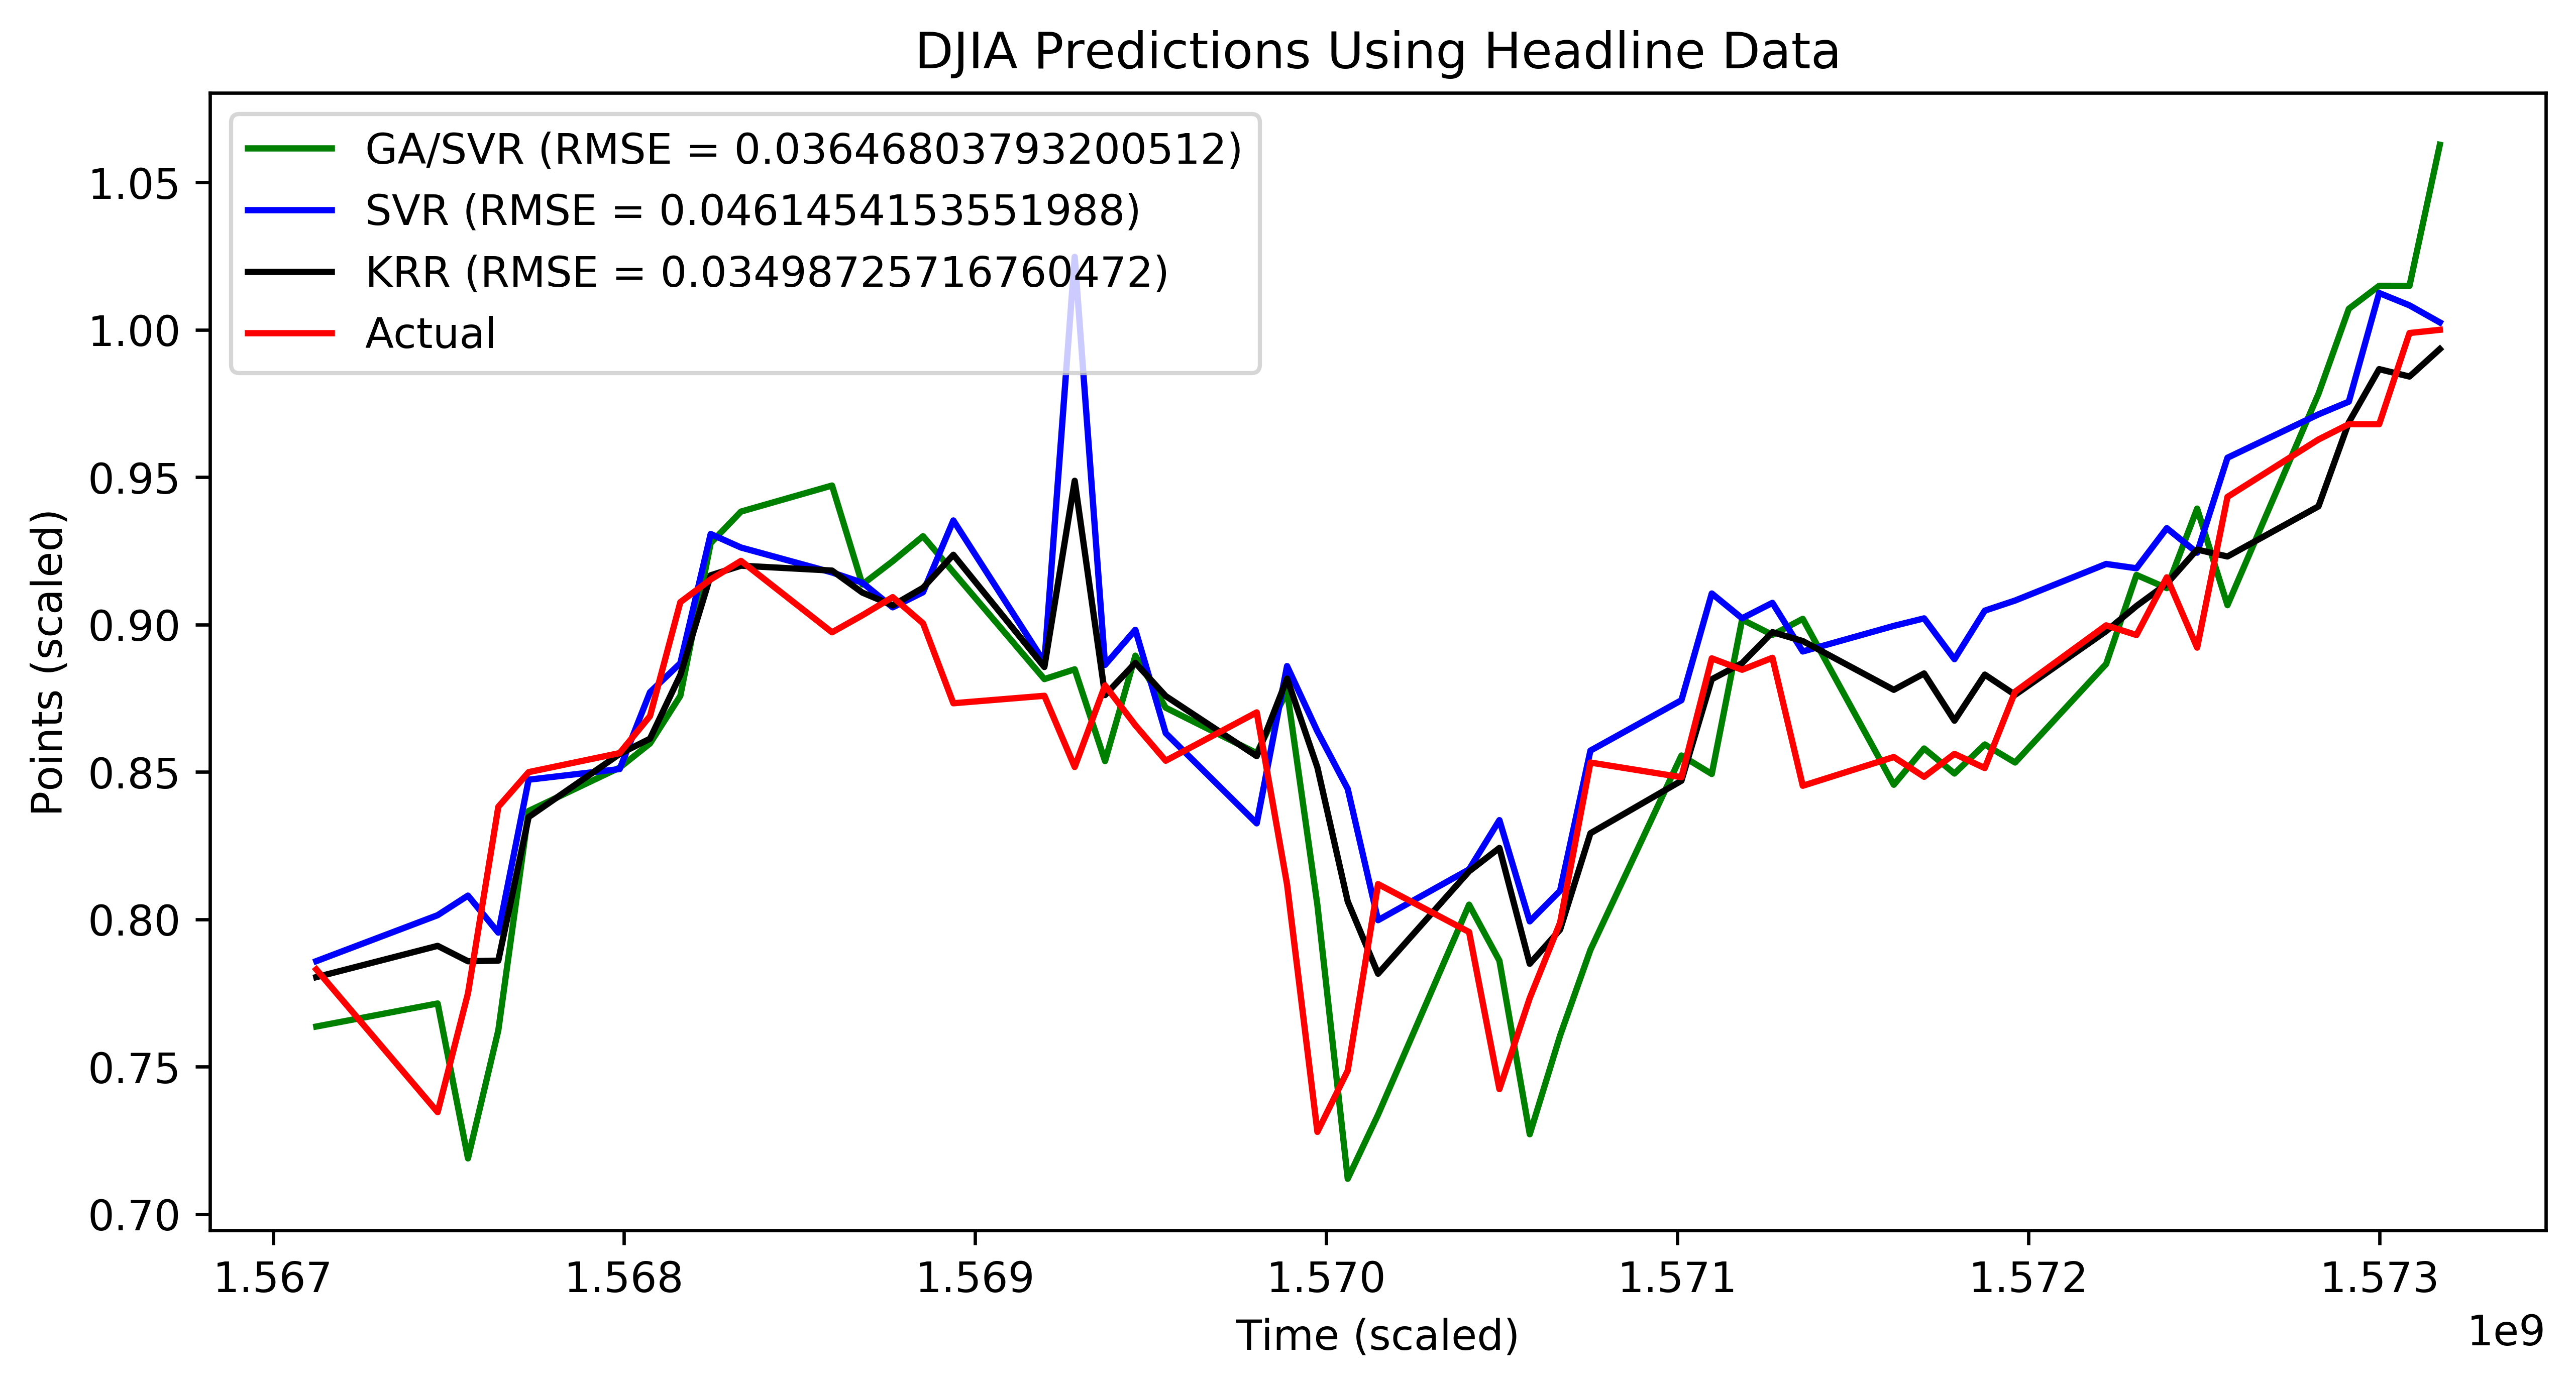

In [4]:
inp = dict_zip(djia_stat, news_stat)
split, actual, res, resga, res_mk = fit(inp)
xs = [x[0] for x in inp[split:]]
plt.plot(xs, resga, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga))) + ")")
plt.plot(xs, res, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res))) + ")")
plt.plot(xs, res_mk, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Headline Data")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-280.01590611    2.515     ]	[1.64972455e+03 1.09076808e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	606   	[-60.01104065   2.595     ]  	[772.26852528   1.01733721]    	[-10000.      0.]	[-0.00847251  5.        ]
2  	603   	[-30.00947911   2.218     ]  	[546.89983658   0.88457673]    	[-10000.      0.]	[-0.00847251  5.        ]
3  	625   	[-40.00892762   1.607     ]  	[631.18878776   0.64385635]    	[-10000.      0.]	[-0.00847251  4.        ]
4  	577   	[-90.00857575   1.183     ]  	[9.44403757e+02 4.57723716e-01]	[-10000.      0.]	[-0.00847251  4.        ]
5  	617   	[-90.00848501   1.035     ]  	[9.44403766e+02 2.48545770e-01]	[-10000.      0.]	[-0.00847251  4.        ]
6  	618   	[-80.00844252   1.026     ]  	[8.90841540e+02 2.08144181e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	636   	[-

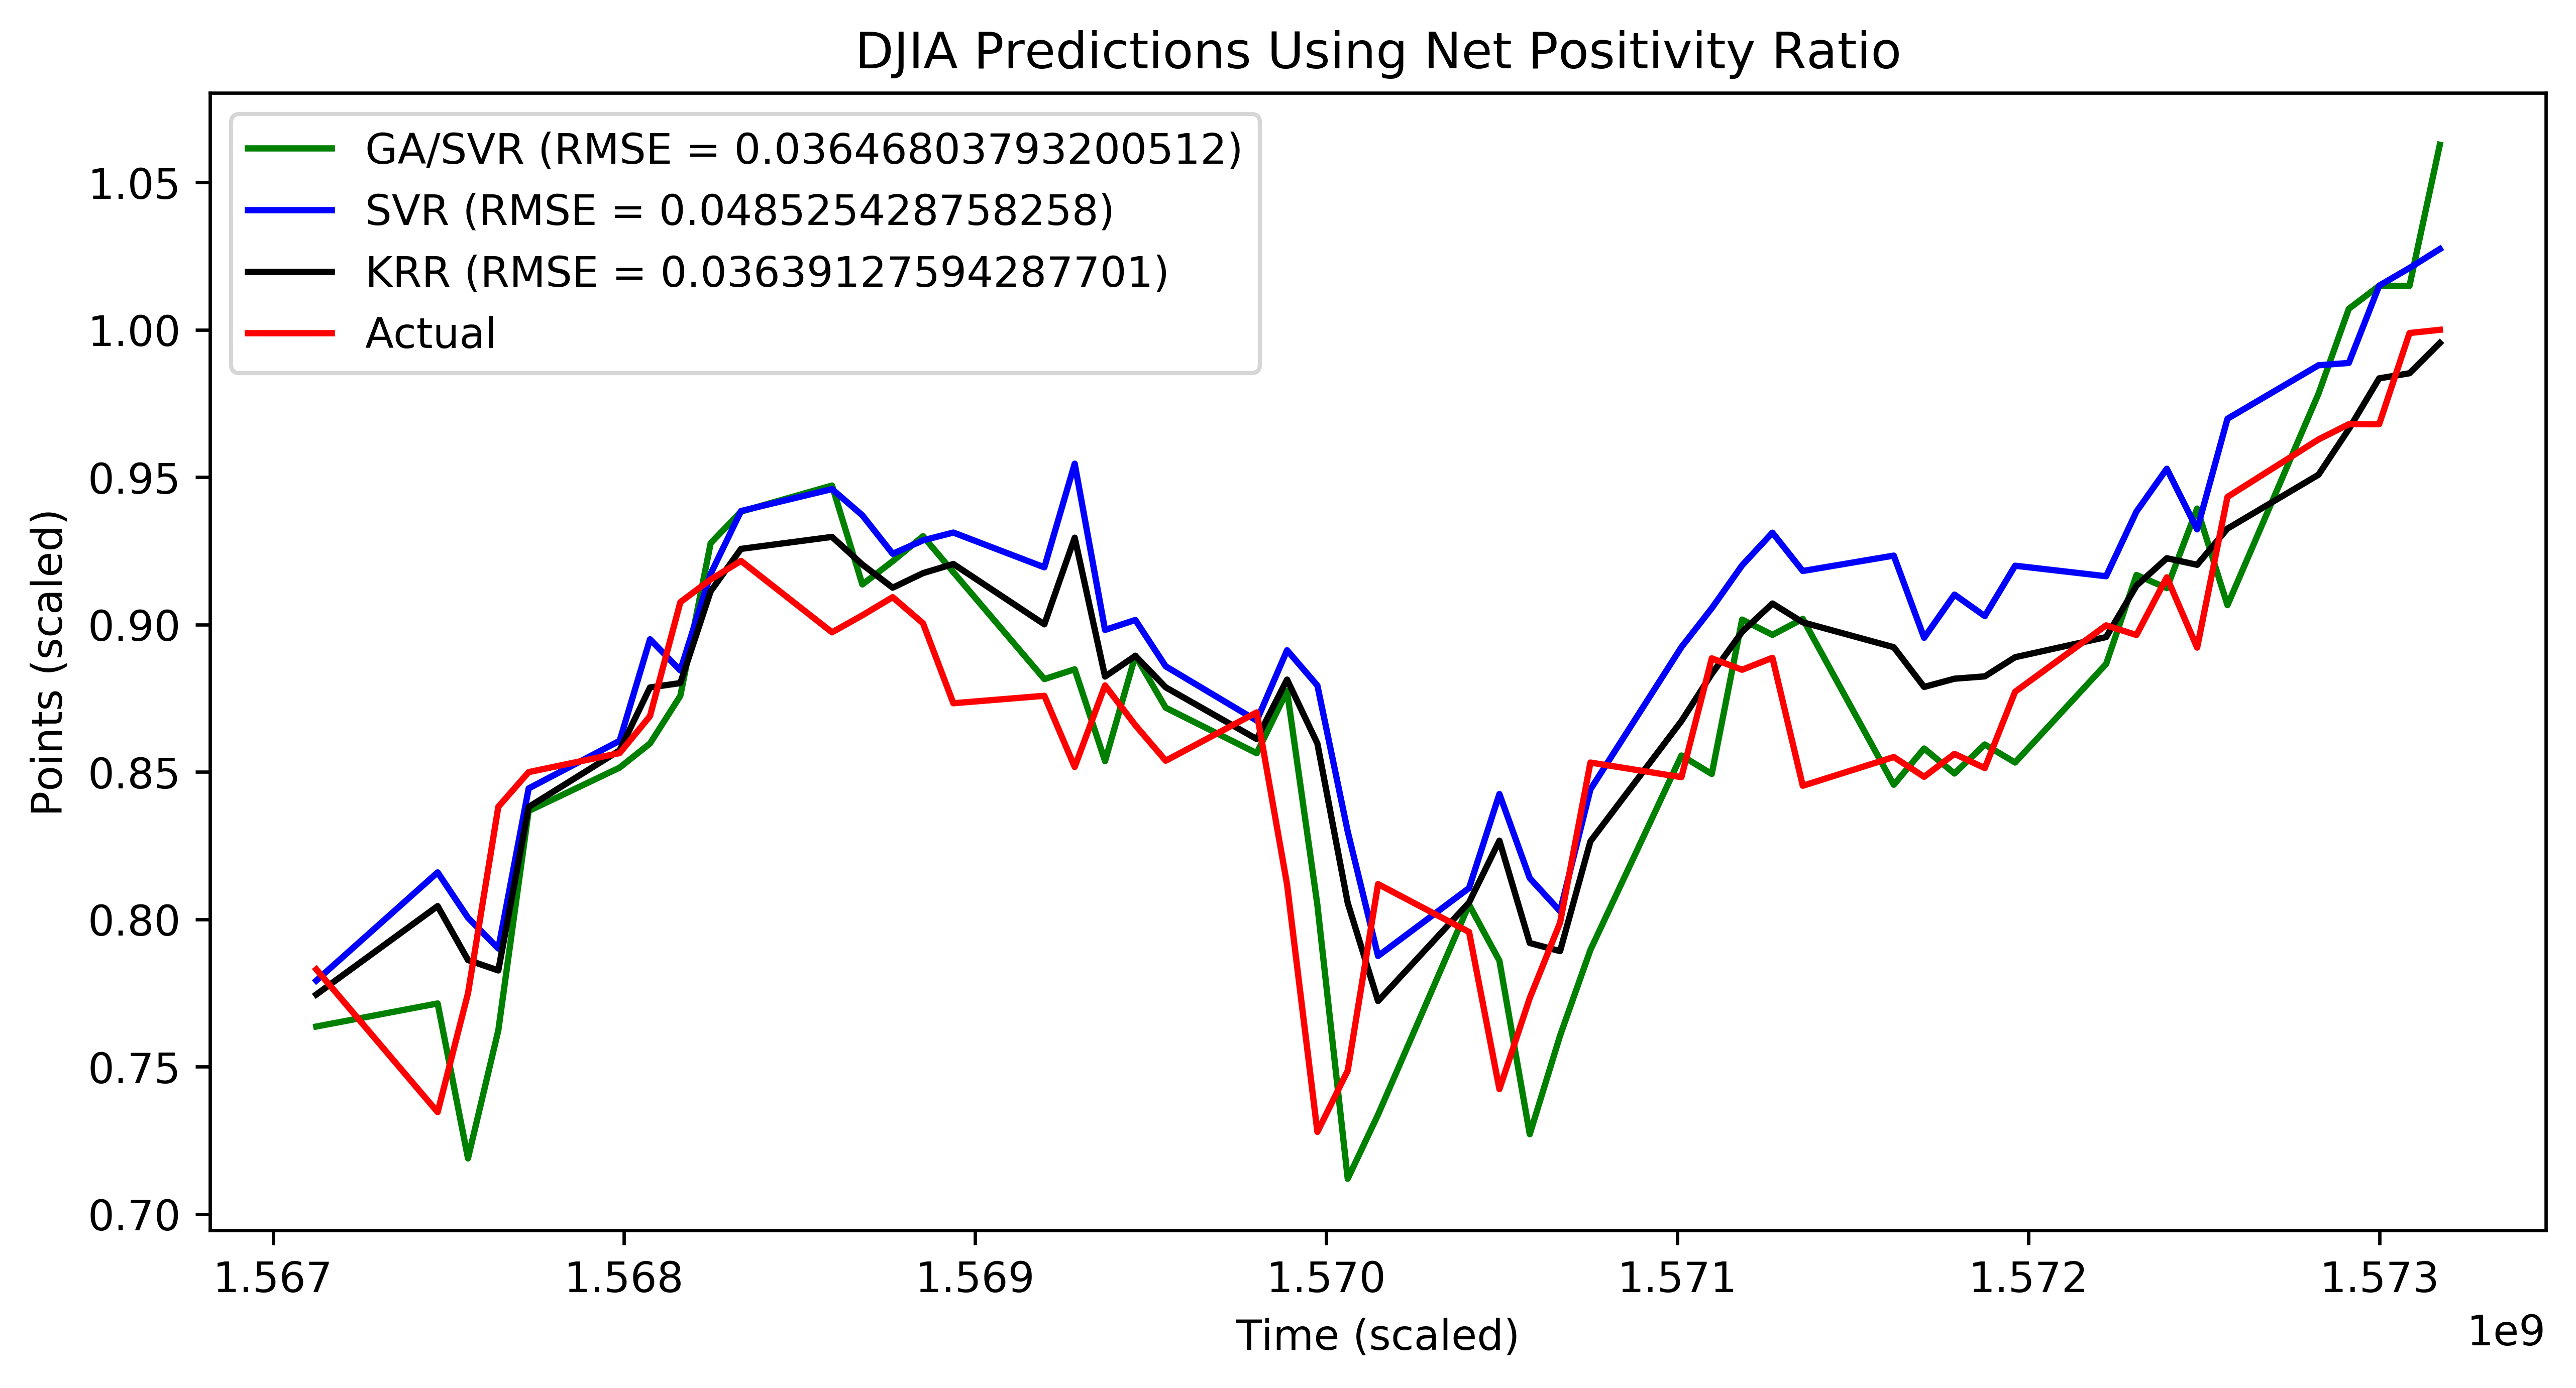

In [5]:
news_stat_ratio = {}
for k, v in news_stat.items():
    news_stat_ratio[k] = [news_stat[k][0], (news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0])]
    
inp2 = dict_zip(djia_stat, news_stat_ratio)
split, actual, res2, resga2, res_mk2 = fit(inp2)
xs = [x[0] for x in inp2[split:]]
plt.plot(xs, resga2, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga2))) + ")")
plt.plot(xs, res2, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res2))) + ")")
plt.plot(xs, res_mk2, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk2))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Net Positivity Ratio")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-350.01596583    2.534     ]	[1.83779455e+03 1.13174379e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	600   	[-90.01114448   2.603     ]  	[944.40351228   1.07302889]    	[-10000.      0.]	[-0.00847251  5.        ]
2  	599   	[-40.00939704   2.086     ]  	[631.18875801   0.90697519]    	[-10000.      0.]	[-0.00847251  5.        ]
3  	569   	[-60.00891034   1.48      ]  	[7.72268691e+02 6.55438784e-01]	[-10000.      0.]	[-0.00847251  4.        ]
4  	602   	[-90.00853405   1.105     ]  	[9.44403761e+02 3.60520457e-01]	[-10000.      0.]	[-0.00847251  4.        ]
5  	601   	[-50.00847554   1.032     ]  	[7.05336198e+02 2.16739475e-01]	[-10000.      0.]	[-0.00847251  3.        ]
6  	596   	[-60.00847628   1.038     ]  	[7.72268725e+02 2.29250954e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	594   	[-

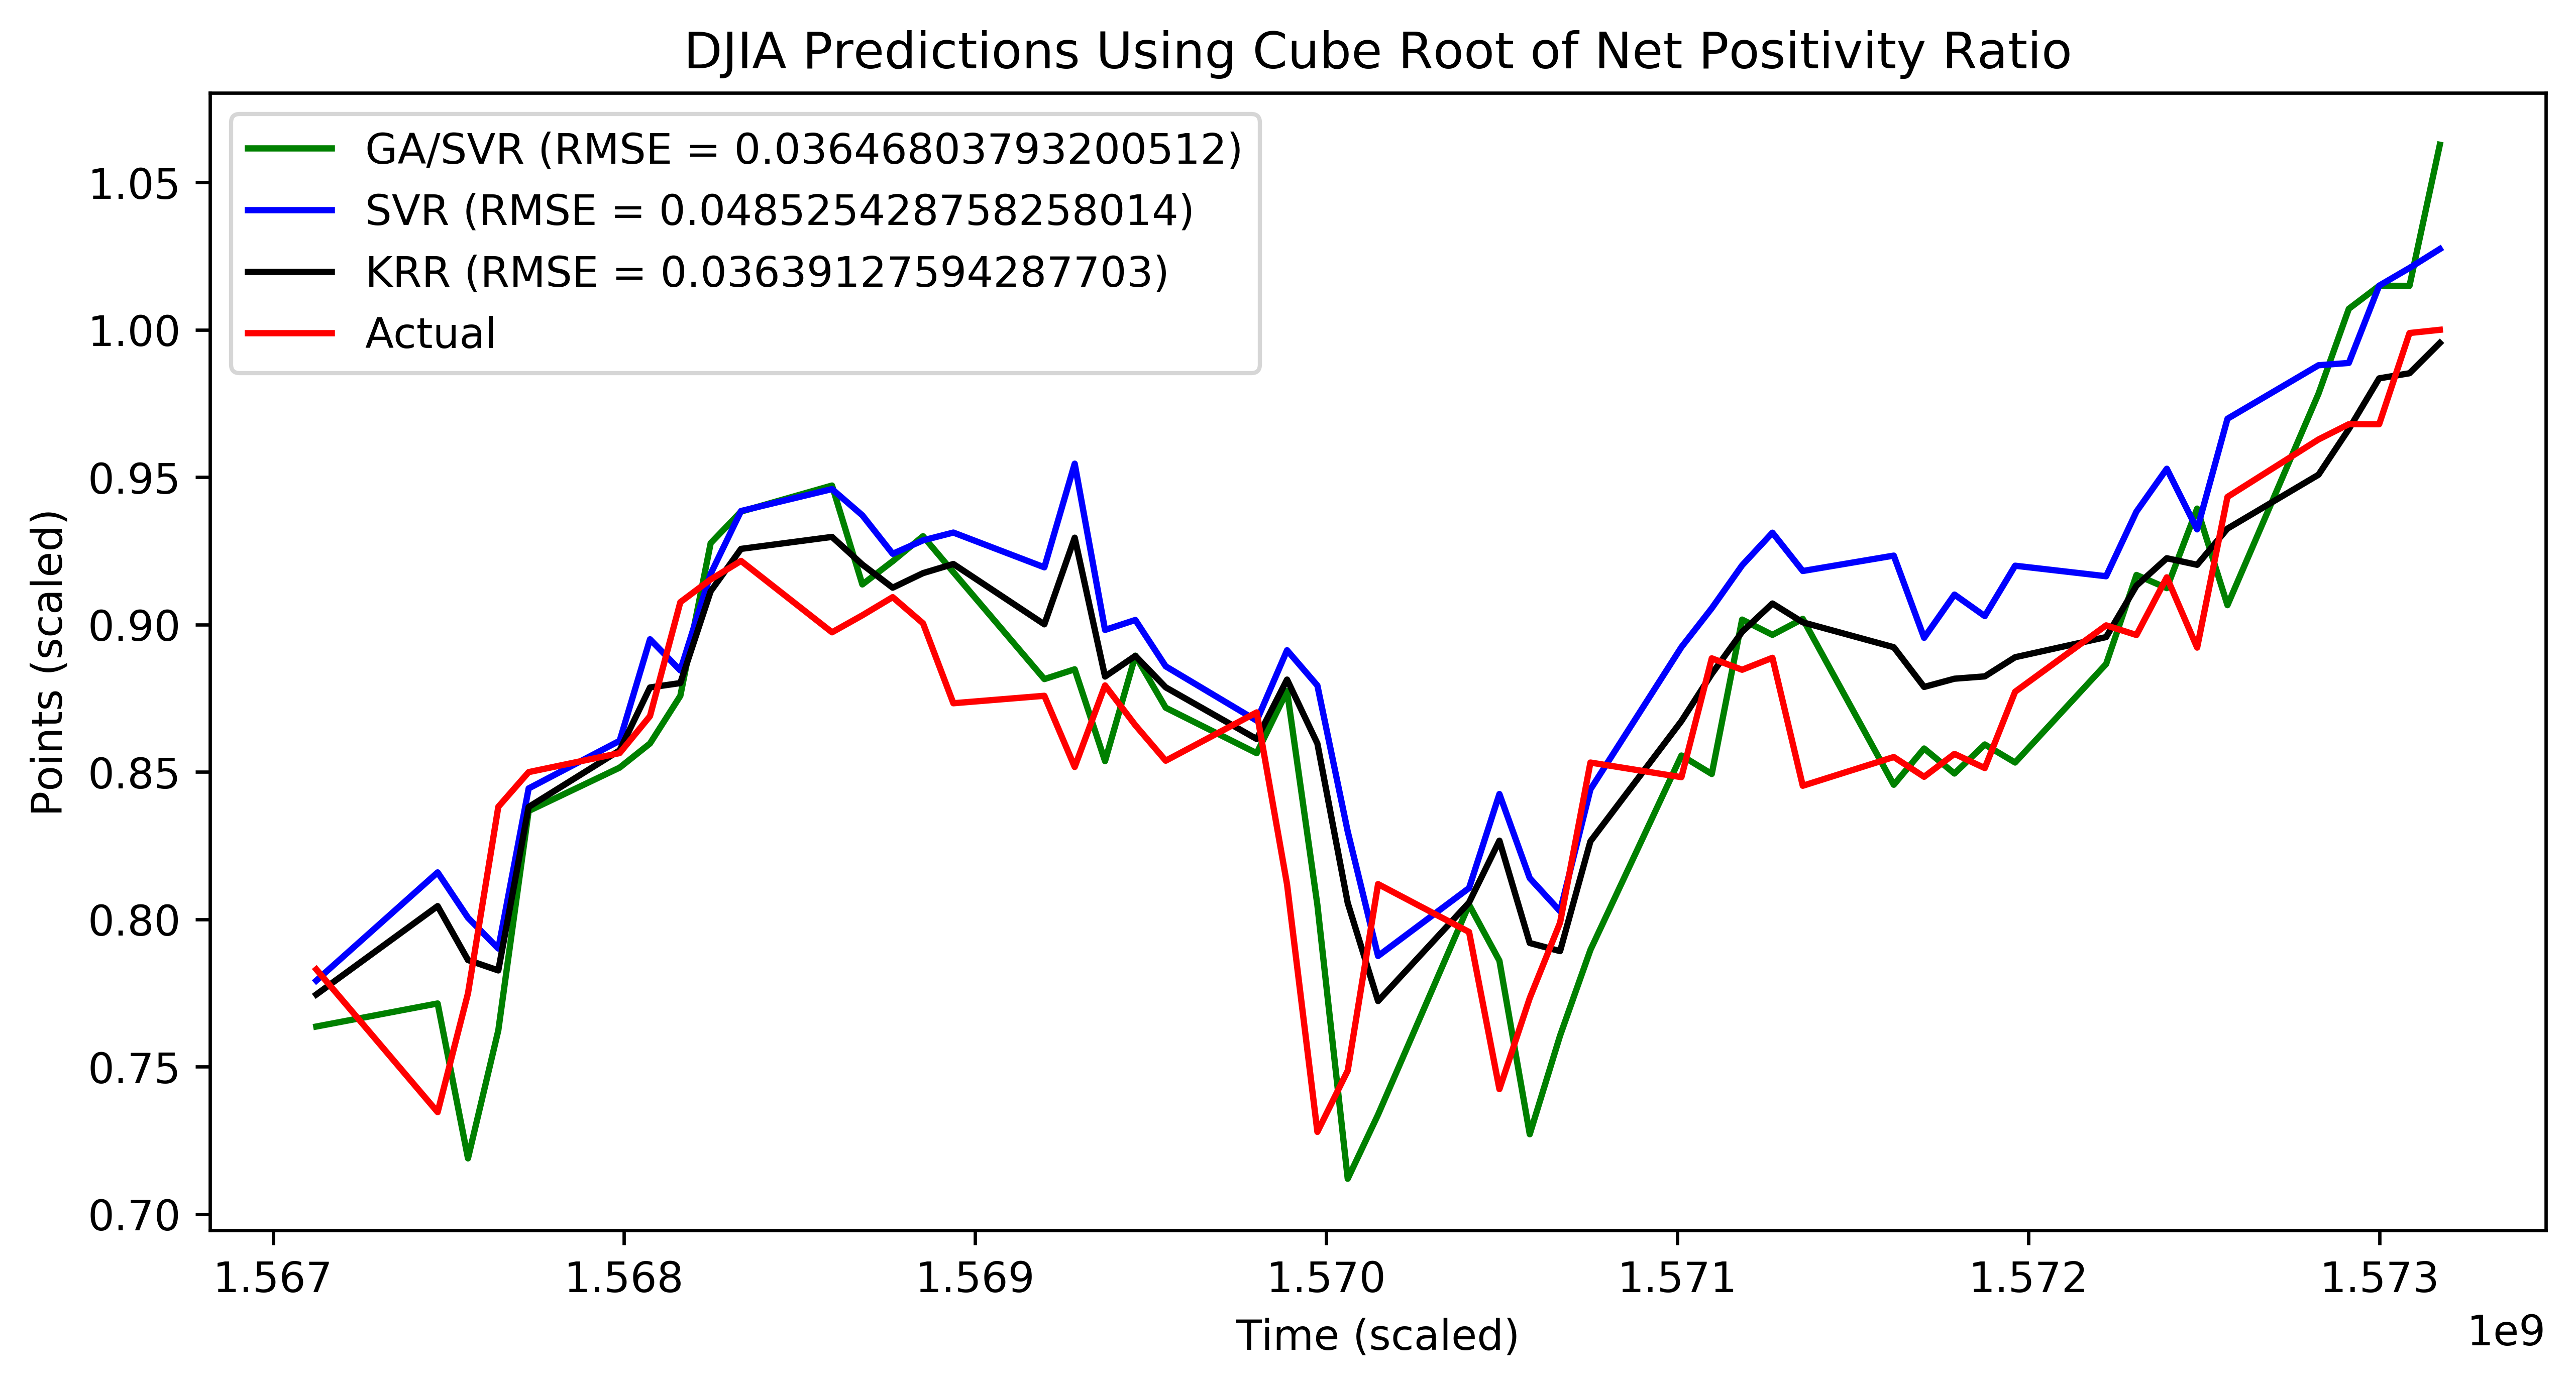

In [6]:
news_stat_ratio_2 = {}
for k, v in news_stat.items():
    news_stat_ratio_2[k] = [news_stat[k][0], ((news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0]) ** 1/3)]
    
inp3 = dict_zip(djia_stat, news_stat_ratio_2)
split, actual, res3, resga3, res_mk3 = fit(inp3)
xs = [x[0] for x in inp3[split:]]
plt.plot(xs, resga3, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga3))) + ")")
plt.plot(xs, res3, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res3))) + ")")
plt.plot(xs, res_mk3, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk3))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Cube Root of Net Positivity Ratio")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

In [7]:
control = {}
for k, v in news_stat.items():
    control[k] = []
    
inp4 = dict_zip(djia_stat, control)
split, actual, res4, resga4, res_mk4 = fit(inp4)
xs = [x[0] for x in inp4[split:]]

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min              	max                      
0  	1000  	[-1380.01075673     1.505     ]	[3.44899555e+03 9.01096554e-01]	[-10000.      0.]	[-0.00847251  3.        ]
1  	636   	[-200.00960007    1.788     ]  	[1.39999863e+03 7.96904009e-01]	[-10000.      0.]	[-0.00847251  3.        ]
2  	620   	[-60.00881416   1.399     ]    	[7.72268698e+02 6.11391037e-01]	[-10000.      0.]	[-0.00847251  3.        ]
3  	600   	[-50.00848551   1.055     ]    	[7.05336197e+02 2.52932797e-01]	[-10000.      0.]	[-0.00847251  3.        ]
4  	619   	[-50.00845115   1.007     ]    	[7.05336200e+02 1.30196006e-01]	[-10000.      0.]	[-0.00847251  2.        ]
5  	580   	[-150.00841481    1.012     ]  	[1.21552354e+03 2.18760143e-01]	[-10000.      0.]	[-0.00847251  3.        ]
6  	640   	[-110.00840032    1.001     ]  	[1.04302356e+03 1.51654212e-01]	[-10000.      0.]	[-0.00847251  2.       

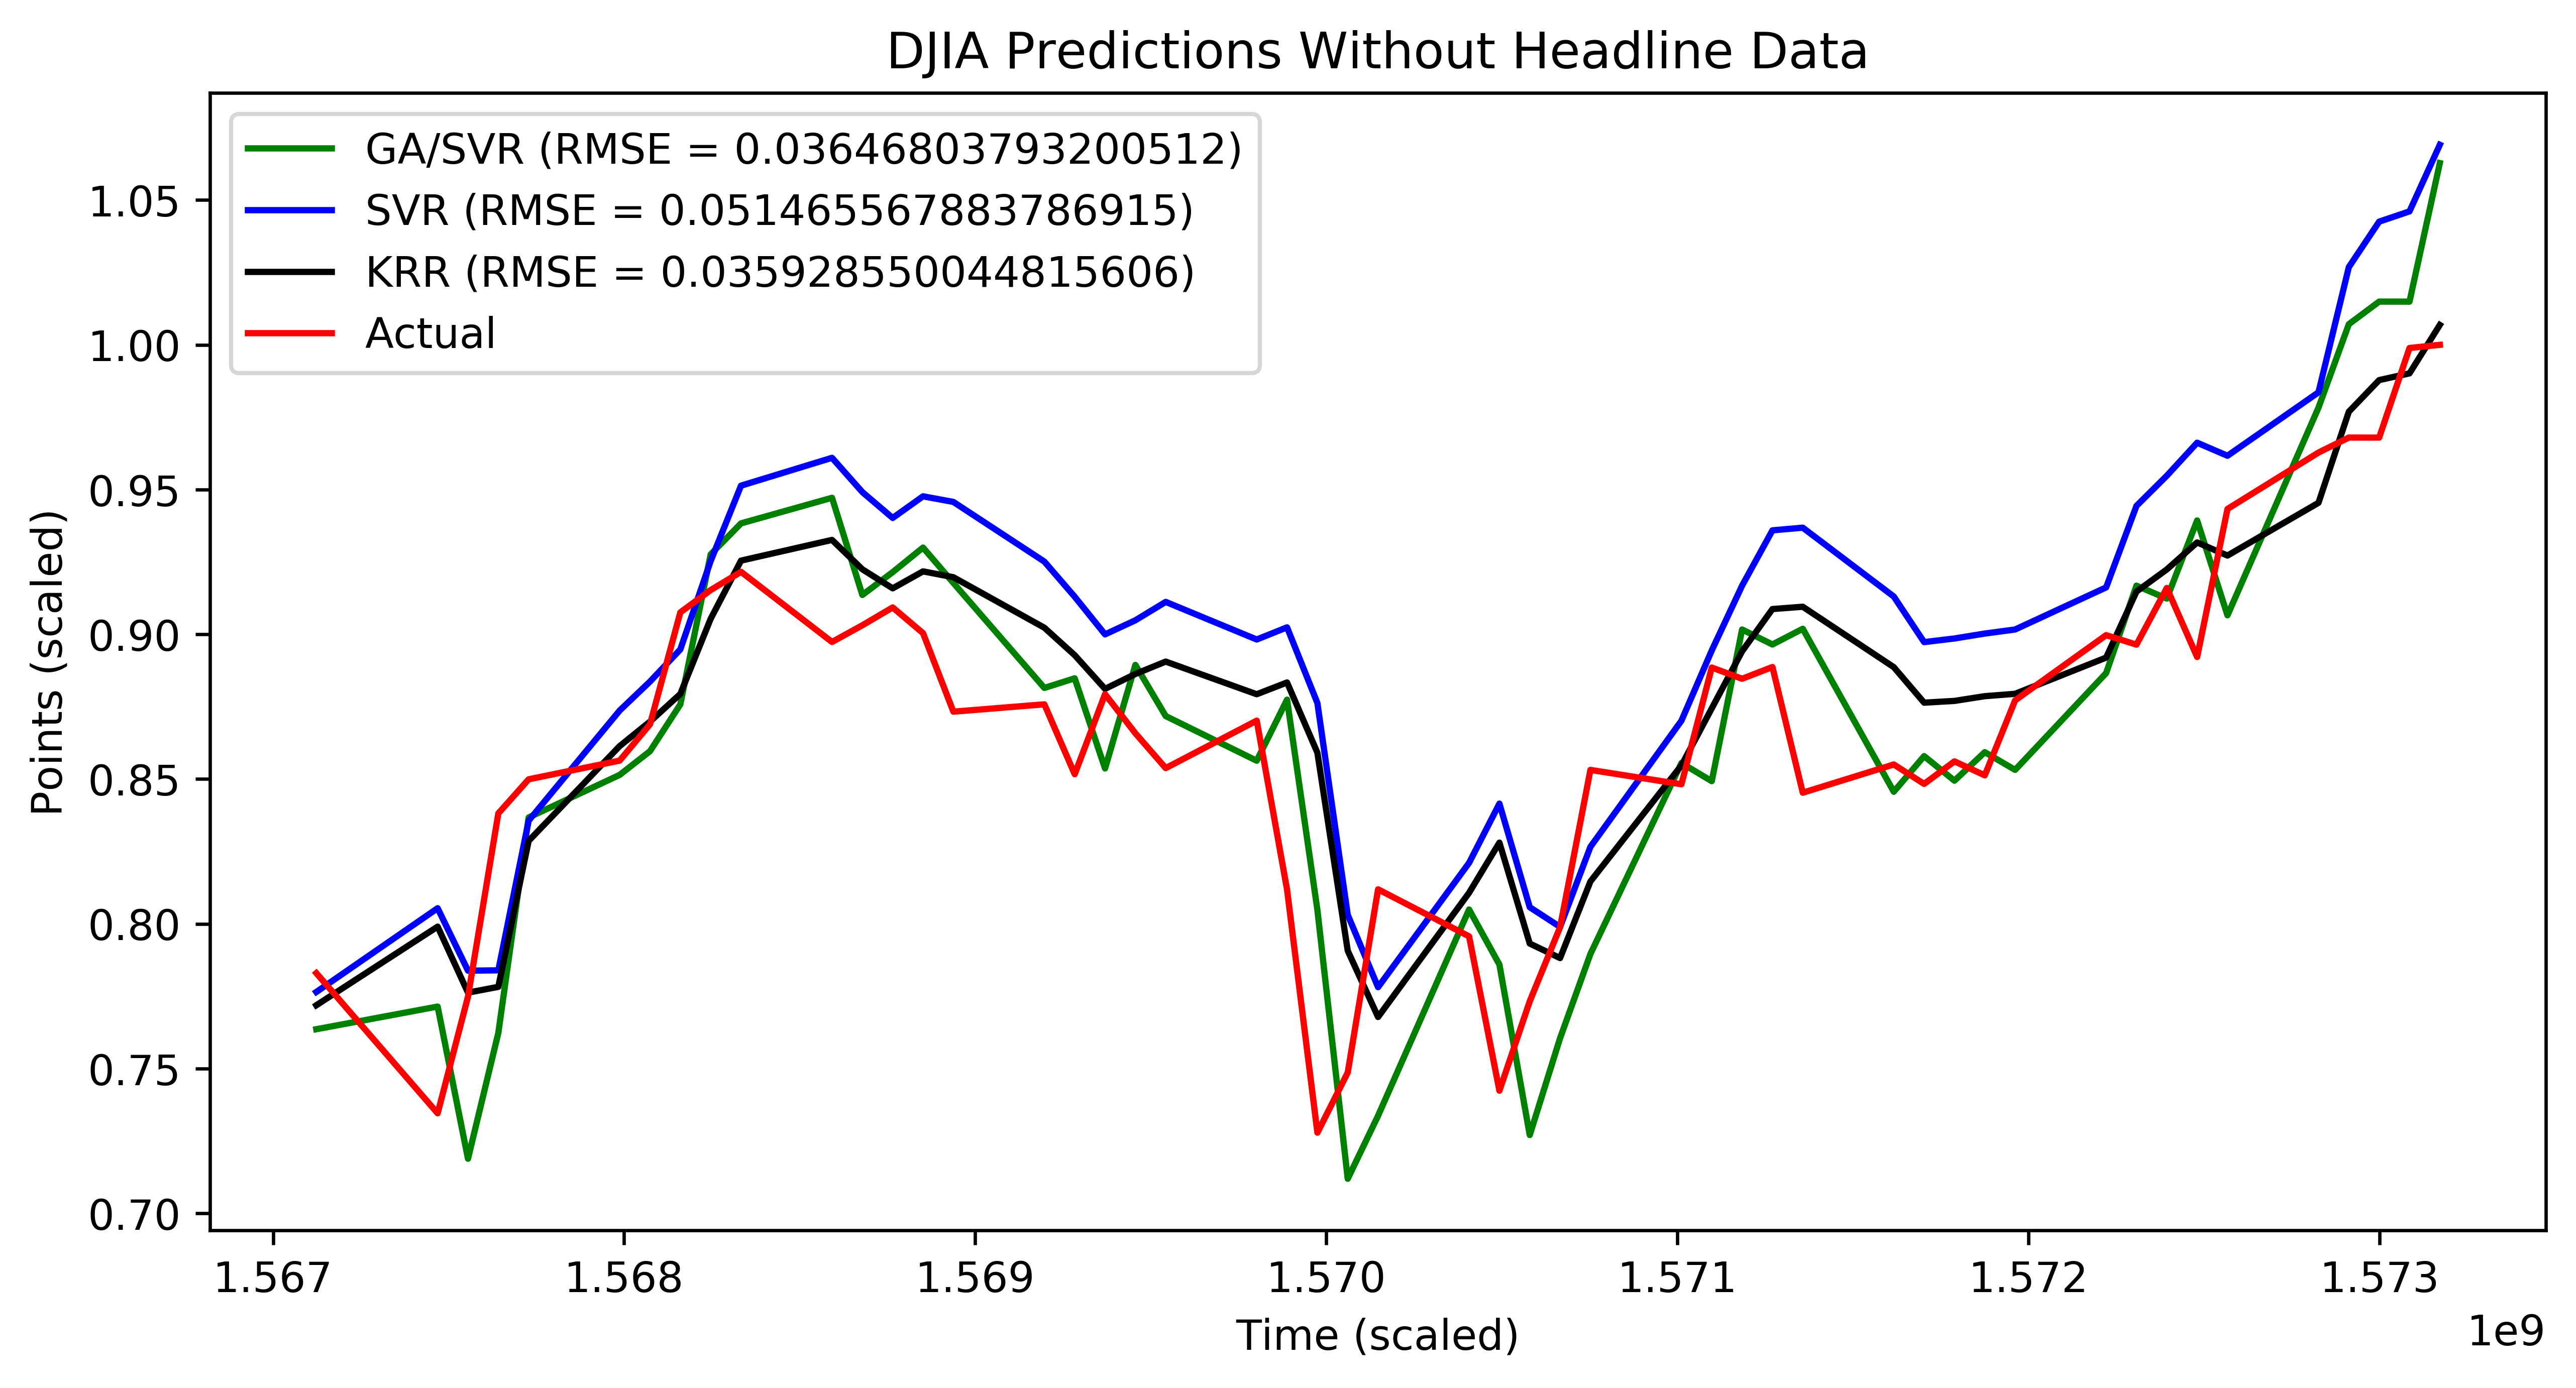

In [9]:
plt.plot(xs, resga4, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga4))) + ")")
plt.plot(xs, res4, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res4))) + ")")
plt.plot(xs, res_mk4, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk4))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Without Headline Data")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()